# Using netCDF files in `xarray` - Part 2

In the second part of exercises with `xarray` we will be taking more specialised subsets of our data (so we can answer questions like "what is the mean water vapour concentration where the temperature is above 30C?") and grouping our data so we can calculate statistics over these groups (answering questions like "what is the quarterly mean temperature over this time period?")

<b>Objectives</b>:

  6.  Masking dataset with .where() function
  
  7.  Using the groupby function on xarray dataset

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [2]:
data_path = Path("../data/")

The xarray where function return elements in the dataset depending on specified condition. The function uses the logical conditional sampling (<,>) and returns True or False.

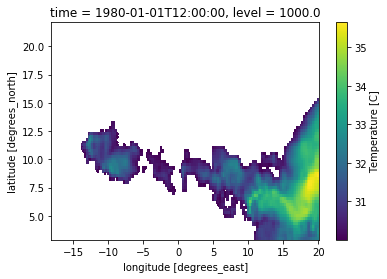

In [3]:
ds = xr.open_dataset(data_path / 'ERA5_temp_rh_West_Africa.nc')

# convert temperature from kelvin to celsius
da_temp_C = ds.t - 273.15
da_temp_C.attrs["units"] = "C"
da_temp_C.attrs["long_name"] = ds.t.long_name

# extract and plot where temperature is > 30 degC
da_temp_hot = da_temp_C.sel(level=1000, time='1980-01-01').where(
    da_temp_C.sel(level=1000,time='1980-01-01')>30
)

da_temp_hot.plot()

<b>The `.groupby()` function</b>

`.groupby()` be used to create groups of your datasets, either along unique values in coordinates or on specific data values. After a `.groupby()` call you can then apply different *aggregations* on these groups, for example calculate the `mean`, `min`, dtc.

The groupby function works very well in calculation of climatologies and anomalies. For time-coordinates in an xarray dataset you can even group by special subsets of time, for example:

* time.hour

* time.day

* time.month

* time.year

* time.season

Since our data contains a single hour (T12) and a single day, let us instead group the dataset 
by month, averaging over the time.

**Notice** the new dimension created (month) after averaging:

In [4]:
ds.groupby('time.month').mean('time')

<xarray.Dataset>
Dimensions:    (latitude: 77, level: 6, longitude: 153, month: 12)
Coordinates:
  * longitude  (longitude) float32 -18.0 -17.75 -17.5 -17.25 ... 19.5 19.75 20.0
  * latitude   (latitude) float32 22.0 21.75 21.5 21.25 ... 3.75 3.5 3.25 3.0
  * level      (level) float64 500.0 600.0 700.0 850.0 925.0 1e+03
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    r          (month, level, latitude, longitude) float32 25.89 25.92 ... 63.03
    t          (month, level, latitude, longitude) float32 260.9 260.9 ... 303.6

In [5]:
# we can similarly group by 'year'
ds.groupby('time.year').mean('time')

<xarray.Dataset>
Dimensions:    (latitude: 77, level: 6, longitude: 153, year: 41)
Coordinates:
  * longitude  (longitude) float32 -18.0 -17.75 -17.5 -17.25 ... 19.5 19.75 20.0
  * latitude   (latitude) float32 22.0 21.75 21.5 21.25 ... 3.75 3.5 3.25 3.0
  * level      (level) float64 500.0 600.0 700.0 850.0 925.0 1e+03
  * year       (year) int64 1980 1981 1982 1983 1984 ... 2017 2018 2019 2020
Data variables:
    r          (year, level, latitude, longitude) float32 14.65 14.64 ... 50.62
    t          (year, level, latitude, longitude) float32 264.2 264.2 ... 305.2

In [6]:
# or by even by season
ds.groupby('time.season').mean('time')

<xarray.Dataset>
Dimensions:    (latitude: 77, level: 6, longitude: 153, season: 4)
Coordinates:
  * longitude  (longitude) float32 -18.0 -17.75 -17.5 -17.25 ... 19.5 19.75 20.0
  * latitude   (latitude) float32 22.0 21.75 21.5 21.25 ... 3.75 3.5 3.25 3.0
  * level      (level) float64 500.0 600.0 700.0 850.0 925.0 1e+03
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    r          (season, level, latitude, longitude) float32 24.58 24.5 ... 70.72
    t          (season, level, latitude, longitude) float32 261.5 ... 302.0

Let's finally demonstrate this by calculating the monthly climatology. We'll group the data by month and subtract the "climatology", which will be the mean of a specific month across all time:

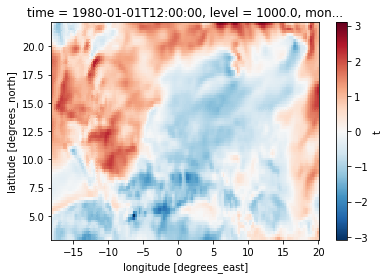

In [7]:
ds_by_month = ds.groupby('time.month')
ds_climatology = ds_by_month.mean(dim="time")
ds_anomalies = ds_by_month - ds_climatology
ds_anomalies.t.sel(level=1000,time='1980-01-01').plot()

In [8]:
# We can see that the climatology has the shape we expect with an entry for each month
ds_climatology

<xarray.Dataset>
Dimensions:    (latitude: 77, level: 6, longitude: 153, month: 12)
Coordinates:
  * longitude  (longitude) float32 -18.0 -17.75 -17.5 -17.25 ... 19.5 19.75 20.0
  * latitude   (latitude) float32 22.0 21.75 21.5 21.25 ... 3.75 3.5 3.25 3.0
  * level      (level) float64 500.0 600.0 700.0 850.0 925.0 1e+03
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    r          (month, level, latitude, longitude) float32 25.89 25.92 ... 63.03
    t          (month, level, latitude, longitude) float32 260.9 260.9 ... 303.6

<b>The resample function</b>

Another means of using the groupby function is the xarray 'resample' function. The xr.ds.resample() returns a Resample object for performing resampling operations. The function handles both downsampling and upsampling. The resampled dimension must be a datetime-like coordinate. http://xarray.pydata.org/en/stable/generated/xarray.Dataset.resample.html

The following frequencies are timescales can be used for resampling.

        ‘AS’: year start
        ‘QS-DEC’: quarterly, starting on December 1
        ‘MS’: month start
        ‘D’: day
        ‘H’: hour
        ‘Min’: minute

    The full list of these offset aliases is documented in pandas: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html.


Downsample the temperature time-series data to seasonal data: This is just like using ds.t.groupby('time.month).mean()

In [9]:
# let's get the quarterly mens
ds_resampled = ds.resample(time="QS-DEC").mean()
ds_resampled

<xarray.Dataset>
Dimensions:    (latitude: 77, level: 6, longitude: 153, time: 165)
Coordinates:
  * time       (time) datetime64[ns] 1979-12-01 1980-03-01 ... 2020-12-01
  * longitude  (longitude) float32 -18.0 -17.75 -17.5 -17.25 ... 19.5 19.75 20.0
  * latitude   (latitude) float32 22.0 21.75 21.5 21.25 ... 3.75 3.5 3.25 3.0
  * level      (level) float64 500.0 600.0 700.0 850.0 925.0 1e+03
Data variables:
    r          (time, level, latitude, longitude) float32 4.074 3.675 ... 29.9
    t          (time, level, latitude, longitude) float32 262.7 262.8 ... 307.6

In [10]:
# `ds_resampled` or any other seasonal dataset can be upsampled to a higher resolution. 
# However, upsample requires interpolation. Interpolation used here is 'linear'.

ds_resampled.resample(time='MS').interpolate('linear')

<xarray.Dataset>
Dimensions:    (latitude: 77, level: 6, longitude: 153, time: 493)
Coordinates:
  * longitude  (longitude) float32 -18.0 -17.75 -17.5 -17.25 ... 19.5 19.75 20.0
  * latitude   (latitude) float32 22.0 21.75 21.5 21.25 ... 3.75 3.5 3.25 3.0
  * level      (level) float64 500.0 600.0 700.0 850.0 925.0 1e+03
  * time       (time) datetime64[ns] 1979-12-01 1980-01-01 ... 2020-12-01
Data variables:
    r          (time, level, latitude, longitude) float64 4.074 3.675 ... 29.9
    t          (time, level, latitude, longitude) float64 262.7 262.8 ... 307.6

<b>Exercise 2</b>:

1. Compute the seasonal climatology and plot for all four (4) seasons. 

2. Compute and plot the seasonal anomaly for relative humidity at 600mb and on 1995-06-01

3. Compute and plot the annual climatology of relative humidity at 600mb, averaged across years.

4. Compute and plot the annual anomaly for relative humidity at 600mb and on 1995-06-01

5. Downsample the relative humidity profile from daily to annual frequency.

6. Upsample the annual rh obtained in Q5 to the monthly frequency.